In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Potato-plant-disease",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)


Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy()) 
    #3 rgb channels

(32, 256, 256, 3)
[1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 2 1 1 0 0 2 0 0 0 1 0 0 0 0 1 2 1]


In [8]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


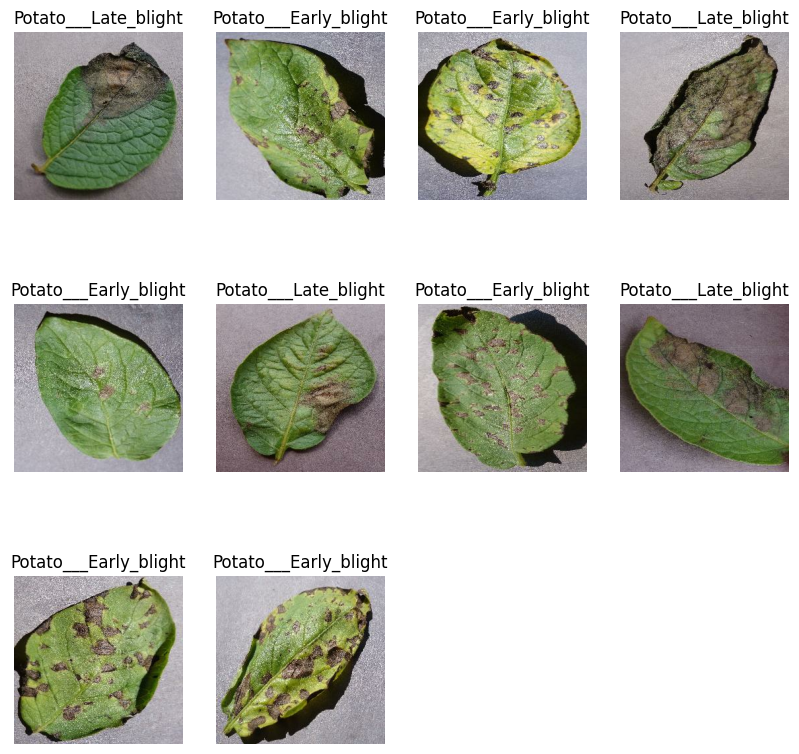

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(10):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
len(dataset)

68

In [11]:
# 80%-training, 10%-validation, 10%-test
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds=dataset.take(54)
len(train_ds)

54

In [13]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [14]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds=dataset.take(6)
len(val_ds)

6

In [16]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    test_size=int(test_split*ds_size) 
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [22]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [25]:
input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

c:\Users\Ananya Sinha\VS code docs\PROJECTS 2\Potato-plant-disease-detector\projenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [28]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds

)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 909ms/step - accuracy: 0.4240 - loss: 0.9617 - val_accuracy: 0.4635 - val_loss: 0.9298
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 998ms/step - accuracy: 0.5575 - loss: 0.8575 - val_accuracy: 0.6198 - val_loss: 0.7286
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 978ms/step - accuracy: 0.6987 - loss: 0.6096 - val_accuracy: 0.7031 - val_loss: 0.6489
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 976ms/step - accuracy: 0.8283 - loss: 0.3992 - val_accuracy: 0.8958 - val_loss: 0.3075
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 969ms/step - accuracy: 0.8724 - loss: 0.2901 - val_accuracy: 0.8906 - val_loss: 0.2019
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 970ms/step - accuracy: 0.8837 - loss: 0.2902 - val_accuracy: 0.9167 - val_loss: 0.2256
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 969ms/step - accuracy: 0.9188 - loss: 0.2206 - val_accuracy: 0.9167 - val_loss: 0.2118
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 964ms/step - accuracy: 0.9261 - loss: 0.1716 - val_accu

In [29]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9873 - loss: 0.0284


In [31]:
scores

[0.030057623982429504, 0.98828125]

In [33]:
history

In [34]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [37]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

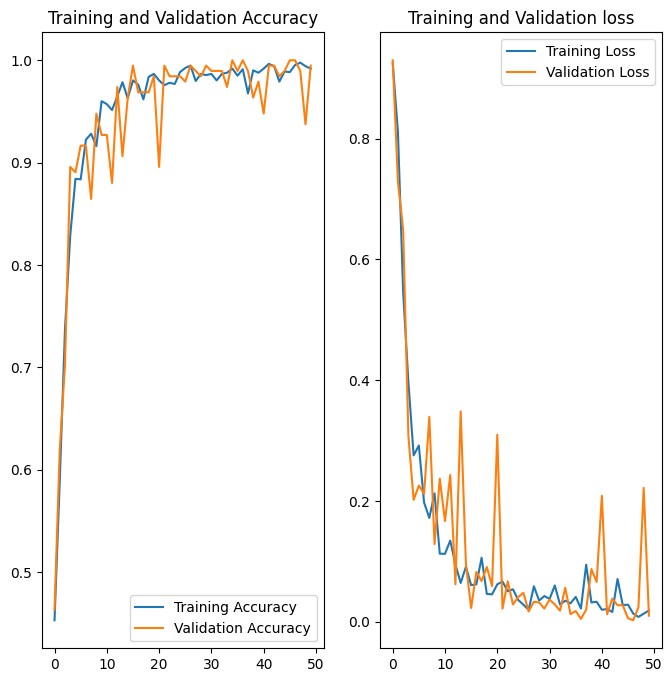

In [42]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Training Loss")
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()





In [57]:
import numpy as np
np.argmax([9.9999869e-01,1.2687169e-06,4.4890968e-13])

np.int64(0)

first image to predict
first label actual: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
predicted label: Potato___Late_blight


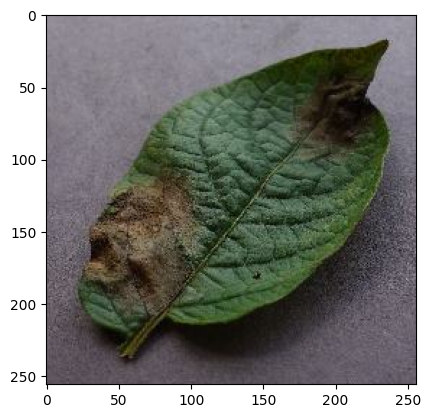

In [61]:
for image_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print('first label actual:',class_names[first_label])

    batch_prediction=model.predict(image_batch)
    print("predicted label:" ,class_names[np.argmax(batch_prediction[0])])


In [67]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)  

    predictions=model.predict(img_array)

    predicted_label=class_names[np.argmax(predictions[0])]
    confidence=round(100 * np.max(predictions[0]), 2)
    return predicted_label, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


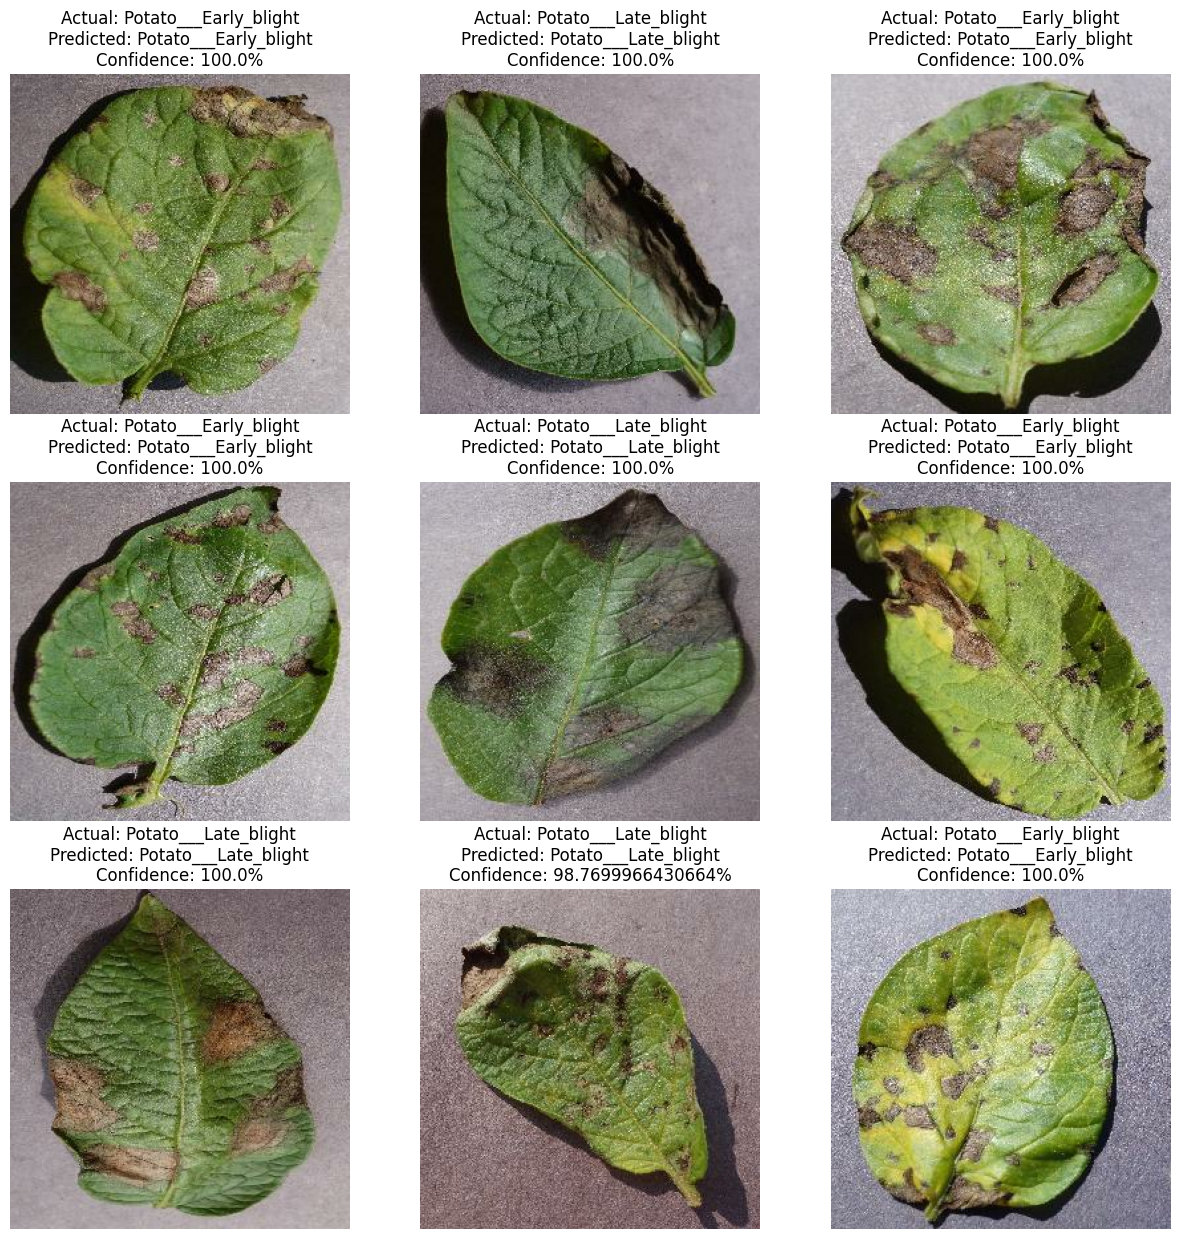

In [69]:
plt.figure(figsize=(15, 15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_label, confidence=predict(model, images[i].numpy())
        actual_label=class_names[labels[i]]
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence}%")
        plt.axis("off")

In [91]:
import os
model_version=max([int(i) for i in os.listdir("models")+[0]])+1
os.makedirs("models", exist_ok=True)

In [90]:
model_version=1
model.export(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets


Saved artifact at 'models/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2716119164608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2716119165840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2716120066608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2716120060272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2716120062032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2716120063792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2716120067664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2716120068544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2716120067136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2716120063968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2716120065376: TensorSpec(shape=(), dtype=

In [92]:
os.listdir("models")

['1']